In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
np.random.seed(1234)
y = np.random.randint(0,4,1200)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 271
1 320
2 292
3 317


In [3]:
x = np.zeros((1200,3))

In [4]:
x[idx[0],0] = 1
x[idx[0],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[0])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[0])//2) + 1 )  ))
x[idx[0],2] = np.random.uniform(low=-0.5,high=-1,size= sum(idx[0])) 



x[idx[1],0] = 1
x[idx[1],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[1])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[1])//2)  )  ))
x[idx[1],2] = np.random.uniform(low=-0.25,high=0.25,size= sum(idx[1])) 



x[idx[2],0] = 1
x[idx[2],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[2])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[2])//2)  )  ))
x[idx[2],2] = np.random.uniform(low=0.50,high=1,size= sum(idx[2])) 




x[idx[3],0] = -1
x[idx[3],1:] = np.random.uniform(low =-1,high=1,size=(sum(idx[3]),2))

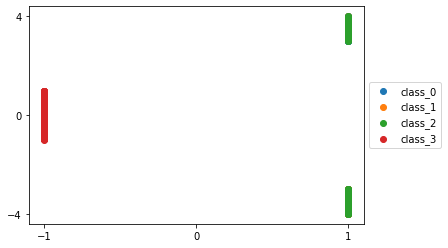

In [5]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-1,0,1])
plt.yticks([-4,0,4])
plt.savefig("dist1.png",bbox_inches="tight")
plt.savefig("dist1.pdf",bbox_inches="tight")


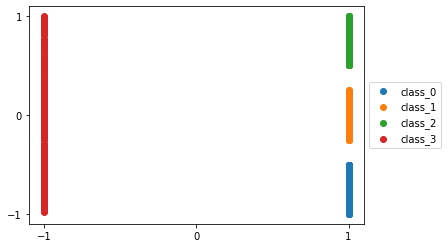

In [6]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],2],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.savefig("dist2.png",bbox_inches="tight")
plt.savefig("dist2.pdf",bbox_inches="tight")


In [7]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3'}

In [8]:

fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,4)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 3 present at 0
background 3 present at 1
background 3 present at 2
background 3 present at 3
background 3 present at 4
background 3 present at 5
background 3 present at 6
background 3 present at 7
foreground 1 present at 8
(9, 3)
1 8


In [9]:
a.shape

(9, 3)

In [10]:
np.reshape(a,(27,1))

array([[-1.        ],
       [ 0.68503853],
       [ 0.65270614],
       [-1.        ],
       [-0.0947877 ],
       [ 0.8926987 ],
       [-1.        ],
       [-0.46513269],
       [-0.7923426 ],
       [-1.        ],
       [-0.87515681],
       [-0.48128579],
       [-1.        ],
       [ 0.28038128],
       [-0.3318334 ],
       [-1.        ],
       [ 0.63985089],
       [-0.40125188],
       [-1.        ],
       [ 0.56035668],
       [ 0.69205427],
       [-1.        ],
       [-0.444971  ],
       [ 0.45695537],
       [ 1.        ],
       [-3.76008122],
       [ 0.13400886]])

In [11]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):  #m=9
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(27,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [12]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [13]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [14]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [15]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(3,1)
        # self.linear2 = nn.Linear(10,20)
        # self.linear3 = nn.Linear(20,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=9
        y = torch.zeros([batch,3], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=2
          x[:,i] = self.helper(z[:,3*i:3*i+3])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,3*i:3*i+3])  #d , dimension =3
        return y , x 

    
    def helper(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [16]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [17]:
torch.manual_seed(1234)
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 3]), torch.Size([250, 9]))

In [18]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(3,3)
        # self.linear2 = nn.Linear(10,20)
        # self.linear3 = nn.Linear(20,3)
    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [19]:
torch.manual_seed(1234)
what = Whatnet().double()
# what(out_where)

In [20]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)  #m=9
    a = []
    for i in range(9): #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(27,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [21]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 27)


In [22]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [23]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 1000

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 1.099
[1,    12] loss: 1.096
[2,     6] loss: 1.097
[2,    12] loss: 1.097
[3,     6] loss: 1.099
[3,    12] loss: 1.094
[4,     6] loss: 1.100
[4,    12] loss: 1.092
[5,     6] loss: 1.097
[5,    12] loss: 1.094
[6,     6] loss: 1.095
[6,    12] loss: 1.095
[7,     6] loss: 1.094
[7,    12] loss: 1.095
[8,     6] loss: 1.095
[8,    12] loss: 1.093
[9,     6] loss: 1.095
[9,    12] loss: 1.092
[10,     6] loss: 1.093
[10,    12] loss: 1.091
[11,     6] loss: 1.091
[11,    12] loss: 1.092
[12,     6] loss: 1.089
[12,    12] loss: 1.091
[13,     6] loss: 1.089
[13,    12] loss: 1.089
[14,     6] loss: 1.087
[14,    12] loss: 1.088
[15,     6] loss: 1.084
[15,    12] loss: 1.087
[16,     6] loss: 1.081
[16,    12] loss: 1.084
[17,     6] loss: 1.082
[17,    12] loss: 1.076
[18,     6] loss: 1.073
[18,    12] loss: 1.074
[19,     6] loss: 1.070
[19,    12] loss: 1.063
[20,     6] loss: 1.058
[20,    12] loss: 1.057
[21,     6] loss: 1.051
[21,    12] loss: 1.043
[22,     6

In [24]:
k1 = 30
k2  = 10

columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = np.array(col2)/k1
df_train[columns[2]] = np.array(col3)/k1
df_train[columns[3]] = np.array(col4)/k1
df_train[columns[4]] = np.array(col5)/k1
df_train[columns[5]] = np.array(col6)/k1
df_train[columns[6]] = np.array(col7)/k1

df_test[columns[0]] = col1
df_test[columns[1]] = np.array(col8)/k2
df_test[columns[2]] = np.array(col9)/k2
df_test[columns[3]] = np.array(col10)/k2
df_test[columns[4]] = np.array(col11)/k2
df_test[columns[5]] = np.array(col12)/k2
df_test[columns[6]] = np.array(col13)/k2

In [25]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0.000000,100.000000,0.000000,35.433333,0.000000,64.566667
1,9,0.000000,100.000000,0.000000,36.366667,0.000000,63.633333
2,14,0.000000,100.000000,1.433333,35.766667,9.133333,53.666667
3,19,0.066667,99.933333,25.333333,16.833333,25.166667,32.666667
4,24,47.333333,52.666667,38.833333,16.933333,12.100000,32.133333
...,...,...,...,...,...,...,...
195,979,100.000000,0.000000,100.000000,0.000000,0.000000,0.000000
196,984,100.000000,0.000000,100.000000,0.000000,0.000000,0.000000
197,989,100.000000,0.000000,100.000000,0.000000,0.000000,0.000000
198,994,100.000000,0.000000,100.000000,0.000000,0.000000,0.000000


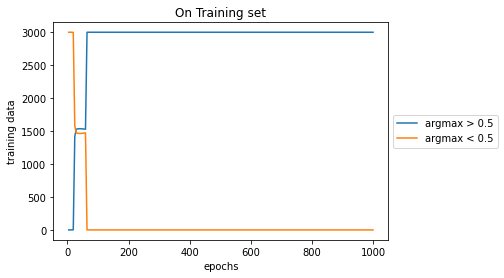

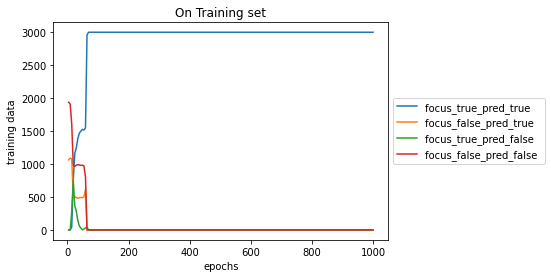

In [26]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("train_analysis.png",bbox_inches="tight")
plt.savefig("train_analysis.pdf",bbox_inches="tight")
plt.show()

In [27]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0.0,100.0,0.0,34.4,0.0,65.6
1,9,0.0,100.0,0.0,36.3,0.0,63.7
2,14,0.0,100.0,4.0,33.7,12.9,49.4
3,19,0.4,99.6,27.3,17.3,21.9,33.5
4,24,48.1,51.9,37.1,17.5,12.1,33.3
...,...,...,...,...,...,...,...
195,979,100.0,0.0,100.0,0.0,0.0,0.0
196,984,100.0,0.0,100.0,0.0,0.0,0.0
197,989,100.0,0.0,100.0,0.0,0.0,0.0
198,994,100.0,0.0,100.0,0.0,0.0,0.0


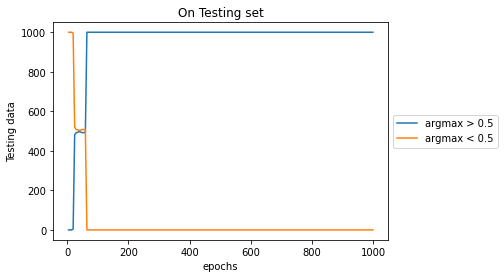

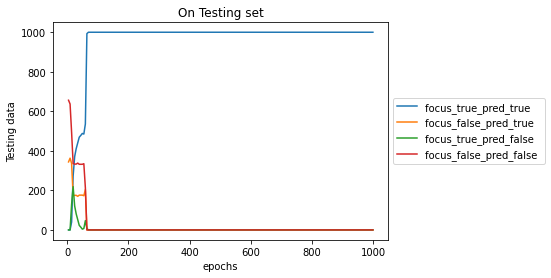

In [28]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.savefig("test_analysis.png",bbox_inches="tight")
plt.savefig("test_analysis.pdf",bbox_inches="tight")
plt.show()

In [29]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [30]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[ 4.3342e+00, -5.1906e-04, -1.7516e-01]], dtype=torch.float64,
       requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-0.1540], dtype=torch.float64, requires_grad=True))


In [31]:
# what.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 4.0075, -2.7007],
#         [-0.7772,  2.6867],
#         [-1.6794,  0.9356]]))
# what.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([-2.7580, -3.0382,  6.3862]))

In [32]:
for param in what.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[ -0.9219,  -0.2479, -13.3611],
        [  1.2201,  -0.1927,   0.2503],
        [ -1.5136,  -0.2196,  13.2658]], dtype=torch.float64,
       requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-1.3156,  1.7504, -0.2290], dtype=torch.float64, requires_grad=True))


In [33]:
xx,yy,zz= np.meshgrid(np.arange(-1.2,1.5,0.01),np.arange(-4.5,4.5,0.01),np.array([-1,0,0.5,1]))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1),zz.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double()
Y = where.helper(X)
Y1 = what(X)

In [34]:
X.shape,Y.shape

(torch.Size([972000, 3]), torch.Size([972000, 1]))

In [35]:
X = X.detach().numpy()
Y = Y[:,0].detach().numpy()

In [36]:
xx.shape,X.shape

((900, 270, 4), (972000, 3))

In [37]:
zz[0,0,1]

0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


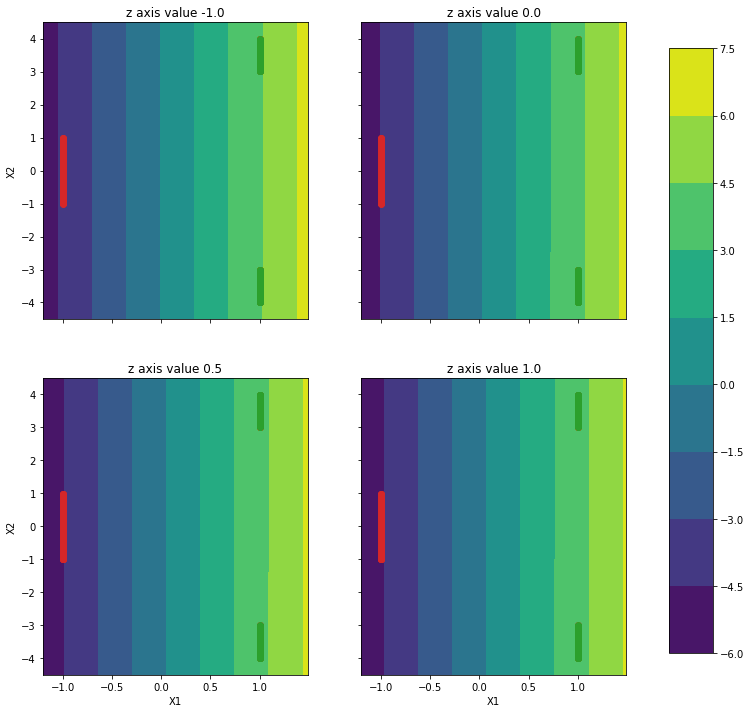

In [38]:
fig,axs = plt.subplots(2,2,figsize=(12,12),sharex=True, constrained_layout=False)
i = 0 
for ax in axs.ravel():
  cs = ax.contourf(X[:,0].reshape(xx.shape)[:,:,i],X[:,1].reshape(yy.shape)[:,:,i],Y.reshape(xx.shape)[:,:,i])
  for j in range(4):
    ax.scatter(x[idx[j],0],x[idx[j],1],label="class_"+str(j))
  ax.set_title("z axis value "+str(zz[0,0,i]))
  i = i+1


for ax in axs.flat:
    ax.set(xlabel='X1', ylabel='X2')

for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cs, cax=cbar_ax)

plt.savefig("focus_illustration.pdf")
plt.savefig("focus_illustration.png")

In [39]:
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
Z3 = Y1[:,2]

In [40]:
Z4

tensor([0, 2, 2,  ..., 1, 2, 2])

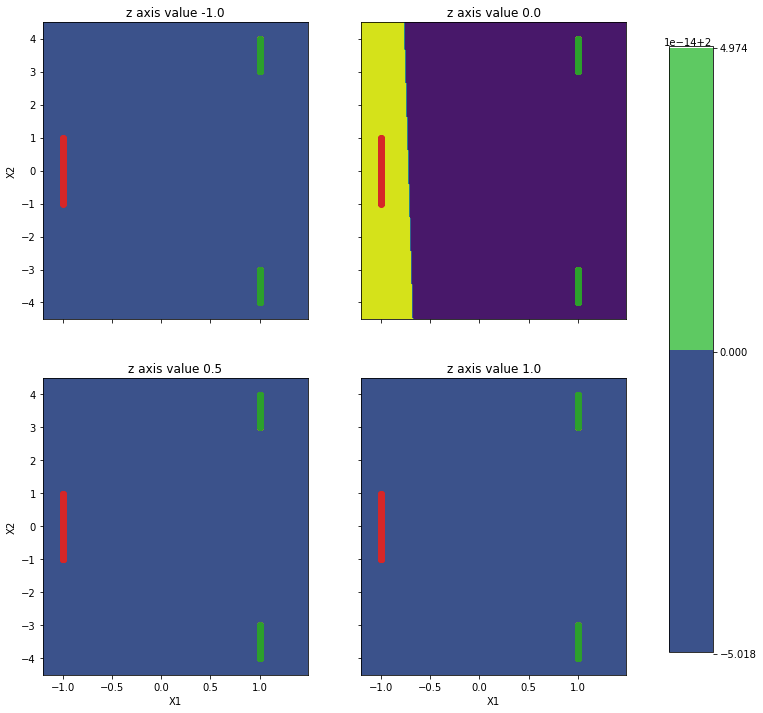

In [48]:
fig,axs = plt.subplots(2,2,figsize=(12,12),sharex=True, constrained_layout=False)
i = 0 
for ax in axs.ravel():
  cs = ax.contourf(X[:,0].reshape(xx.shape)[:,:,i],X[:,1].reshape(yy.shape)[:,:,i],Z4.reshape(xx.shape)[:,:,i])
  for j in range(4):
    ax.scatter(x[idx[j],0],x[idx[j],1],label="class_"+str(j))
  ax.set_title("z axis value "+str(zz[0,0,i]))
  i = i+1


for ax in axs.flat:
    ax.set(xlabel='X1', ylabel='X2')

for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cs, cax=cbar_ax)

plt.savefig("classification_illustration.pdf")
plt.savefig("classification_illustration.png")

In [42]:
avrg = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
avrg= np.concatenate(avrg,axis=0)

In [43]:
avrg

array([[ 0.99751736, -3.08888577, -0.97178748],
       [ 0.99773184, -3.47758179, -0.90847416],
       [ 0.99740984, -3.19334668, -0.24579348],
       ...,
       [ 0.99733641, -3.14451281, -0.11912427],
       [ 0.99697787,  3.08566272,  0.18990613],
       [ 0.99709827, -3.78482198,  0.19765654]])

In [44]:
# cs = plt.contourf(X[:,0].reshape(xx.shape)[:,:,0],X[:,1].reshape(yy.shape)[:,:,0],Z4.reshape(xx.shape)[:,:,1])
# for i in range(4):
#     plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.scatter(avrg[:,0],avrg[:,1])
# plt.savefig("decision_boundary.png",bbox_inches="tight")

In [45]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [46]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[ 944,    0,    0],
       [   0, 1013,    0],
       [   0,    0, 1043]])